In [14]:
# !pip install --upgrade transformers bitsandbytes
# !pip install numpy==1.24.2

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())


True
1


Device set to use cuda:0


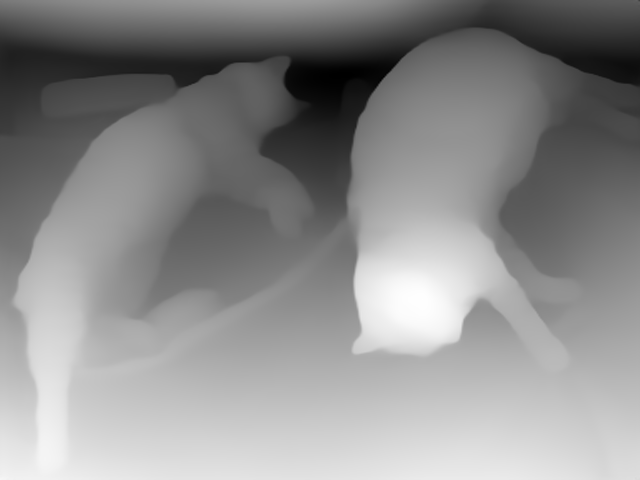

In [7]:
from transformers import pipeline

pipe = pipeline(task="depth-estimation", model="Intel/dpt-beit-base-384")
result = pipe("http://images.cocodataset.org/val2017/000000039769.jpg")
result["depth"]


In [32]:
%%timeit
result = pipe("https://www.thinkrightme.com/wp-content/uploads/2023/03/wildlife-sanctuaries-around-the-world-feature-image-1024x610.jpg")
result["depth"]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


1.91 s ± 79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Note, if you don't want to reinstall BNBs dependencies, append the `--no-deps` flag!
#!pip install --force-reinstall 'https://github.com/bitsandbytes-foundation/bitsandbytes/releases/download/continuous-release_multi-backend-refactor/bitsandbytes-0.44.1.dev0-py3-none-manylinux_2_24_x86_64.whl'

In [1]:
# import torch
# from transformers import DPTForDepthEstimation,BitsAndBytesConfig

# if torch.cuda.is_bf16_supported():
#   compute_dtype = torch.bfloat16
# else:
#   compute_dtype = torch.float16

# model_name = "Intel/dpt-beit-base-384"
# quant_path = 'Intel/dpt-beit-base-384-bnb-4bit'
# # tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=compute_dtype,
#         bnb_4bit_use_double_quant=True,
# )
# model = DPTForDepthEstimation.from_pretrained(
#           model_name, quantization_config=bnb_config
# )


# model.save_pretrained("./"+"Quantized-"+quant_path, safetensors=True)
# tokenizer.save_pretrained("./"+quant_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.15k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:

import torch
from transformers import DPTForDepthEstimation, DPTImageProcessor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


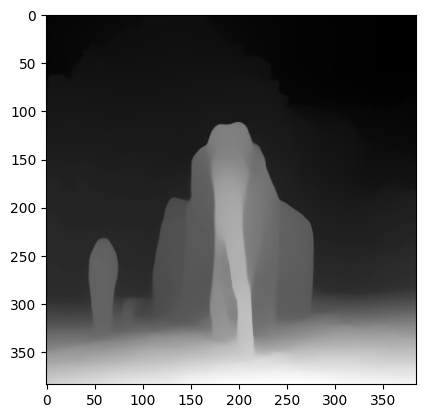

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


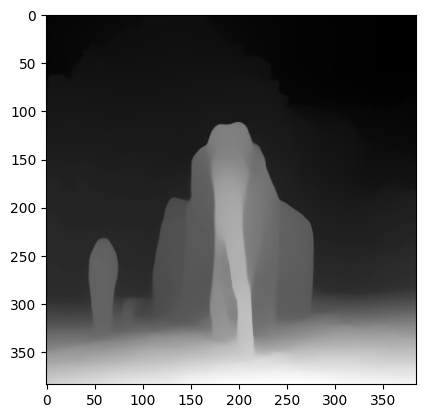

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


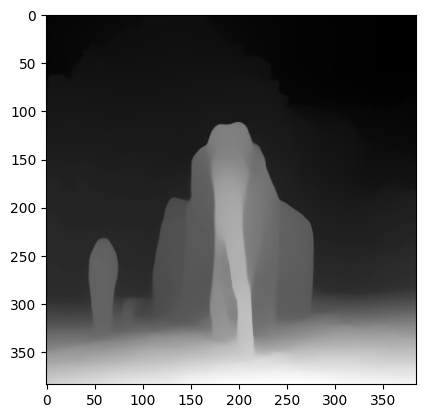

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


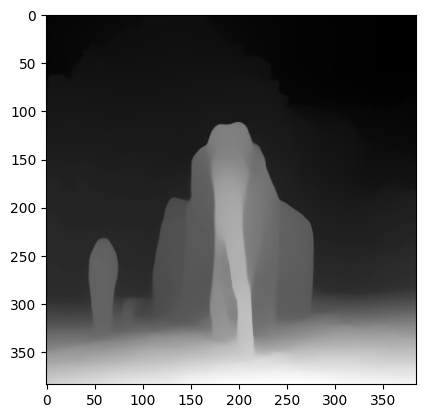

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


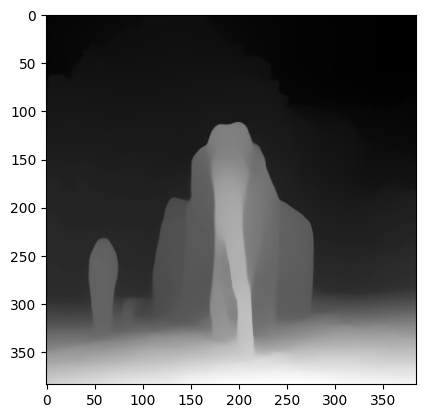

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


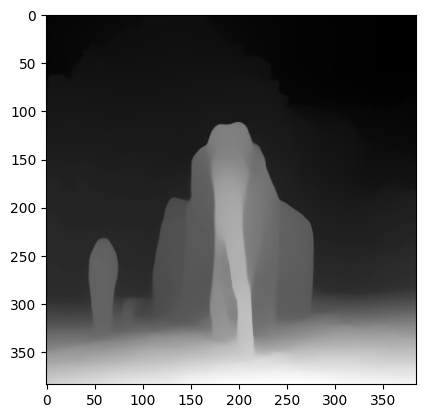

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


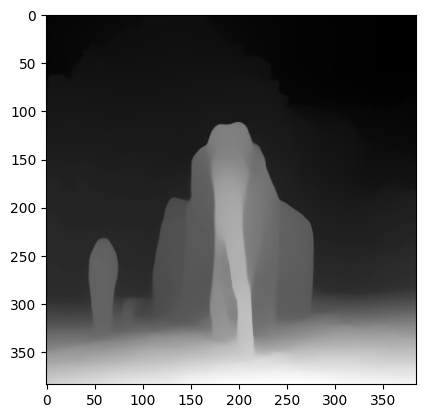

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


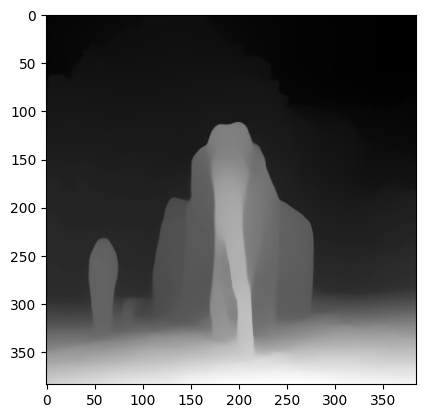

1.35 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit

# Define the path to the saved quantized model
quantized_model_path = "./Quantized-Intel/dpt-beit-base-384-bnb-4bit"

# Load the quantized model
model = DPTForDepthEstimation.from_pretrained(
    quantized_model_path,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,  # Ensure correct dtype
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the image processor
image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-base-384")

# Set the model to evaluation mode
model.eval()


image_path = "/content/wildlife1.jpg"  # Replace with the path to your image
image = Image.open(image_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt")

# Convert inputs to the same device and precision as the model
inputs = {key: value.to(device).to(torch.float16) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Post-process the depth map (optional, to visualize or normalize it)
predicted_depth = predicted_depth.squeeze().cpu().numpy()

# Visualize or save the result
plt.imshow(predicted_depth, cmap="grey")
plt.show()


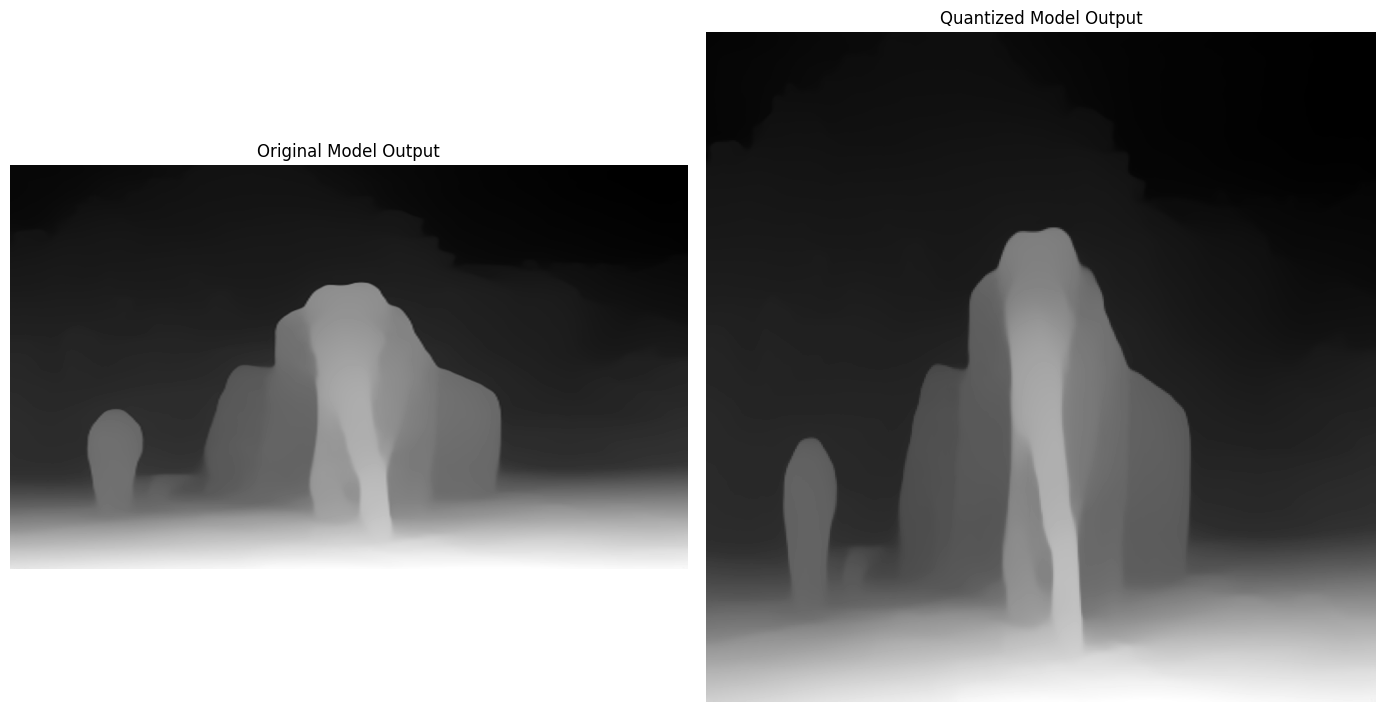

In [31]:
# Compare the original and quantized model outputs
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Original model
axes[0].imshow(result['depth'], cmap="gray")
axes[0].set_title("Original Model Output")
axes[0].axis("off")
# Quantized model
axes[1].imshow(predicted_depth, cmap="gray")
axes[1].set_title("Quantized Model Output")
axes[1].axis("off")

plt.tight_layout()
plt.show()
